In [178]:
import pandas as pd
from sklearn.preprocessing import label_binarize
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import LeavePGroupsOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from dataprep.eda import create_report

In [179]:
def train_test_split_per_user(data, train_size=0.8, target_column='label_negative_affect_category'):
    users = list(set(data.id))
    users = sorted(users, reverse=True)  # fix randomness
    total_users = len(users)
    slice_idx = int(train_size * total_users)
    users_train = users[:slice_idx]
    users_test = users[slice_idx:]
    
    # Split data based on user IDs
    train_data = data[data.id.isin(users_train)]
    test_data = data[data.id.isin(users_test)]
    
    x_train = train_data.drop(['id', target_column], axis=1) 
    y_train = train_data[target_column]  
    x_test = test_data.drop(['id', target_column], axis=1) 
    y_test = test_data[target_column]  
    
    return x_train, y_train, x_test, y_test

In [180]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

In [181]:
df = pd.read_pickle('../data/lifesnaps/data_unprocessed.pkl')
df = df[df['label_panas_negative_affect'].notna()]
df = df.drop(columns=['label_ttm_stage', 'label_breq_self_determination', 'label_sema_negative_feelings', 'label_ipip_extraversion_category',
                      'label_ipip_agreeableness_category', 'label_ipip_conscientiousness_category', 'label_ipip_stability_category', 
                      'label_ipip_intellect_category', 'label_stai_stress_category', 'startTime', 'endTime', 'date', 'badgeType', 'activityType',
                     'heart_rate_alert', 'mindfulness_session'])
df

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,label_panas_negative_affect
499,621e2f3967b776a240c654db,33.124766,75.366,22.920,NaN,16.6,75.0,0.933333,0.800,0.500000,...,1.373737,5765.0,153.0,1169.0,0.0,0.0,>=30,MALE,24.0,Below average
500,621e2f3967b776a240c654db,33.124766,75.366,22.920,NaN,16.6,75.0,0.933333,0.800,0.500000,...,1.373737,5765.0,153.0,1169.0,0.0,0.0,>=30,MALE,24.0,Below average
501,621e2f3967b776a240c654db,33.124766,75.366,22.920,NaN,16.6,75.0,0.933333,0.800,0.500000,...,1.373737,5765.0,153.0,1169.0,0.0,0.0,>=30,MALE,24.0,Below average
510,621e329067b776a2402ffad2,33.511807,NaN,NaN,NaN,NaN,86.0,0.966667,0.925,0.666667,...,1.129870,14021.0,657.0,752.0,31.0,0.0,>=30,MALE,23.0,Average
511,621e329067b776a2402ffad2,33.511807,NaN,NaN,NaN,NaN,86.0,0.966667,0.925,0.666667,...,1.129870,14021.0,657.0,752.0,31.0,0.0,>=30,MALE,23.0,Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,621e339967b776a240e502de,34.097435,51.664,47.480,95.5,12.4,79.0,0.866667,0.725,0.800000,...,1.054348,4168.0,29.0,1344.0,8.0,0.0,<30,FEMALE,20.0,Below average
7723,621e2f9167b776a240011ccb,34.359505,59.255,26.811,95.4,15.4,76.0,0.700000,0.800,0.766667,...,0.742857,3120.0,139.0,1214.0,0.0,0.0,>=30,FEMALE,20.0,Above average
7724,621e2f9167b776a240011ccb,34.359505,59.255,26.811,95.4,15.4,76.0,0.700000,0.800,0.766667,...,0.742857,3120.0,139.0,1214.0,0.0,0.0,>=30,FEMALE,20.0,Above average
7785,621e367e67b776a24087d75d,33.189233,54.651,40.814,NaN,11.6,NaN,NaN,NaN,NaN,...,NaN,6447.0,90.0,1350.0,0.0,0.0,None,MALE,None,Average


In [182]:
df.columns

Index(['id', 'nightly_temperature', 'nremhr', 'rmssd', 'spo2',
       'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage',
       'exertion_points_percentage', 'responsiveness_points_percentage',
       'daily_temperature_variation', 'calories', 'filteredDemographicVO2Max',
       'distance', 'bpm', 'lightly_active_minutes',
       'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes',
       'scl_avg', 'resting_hr', 'sleep_duration', 'minutesToFallAsleep',
       'minutesAsleep', 'minutesAwake', 'minutesAfterWakeup',
       'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio',
       'sleep_light_ratio', 'sleep_rem_ratio', 'steps',
       'minutes_in_default_zone_1', 'minutes_below_default_zone_1',
       'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age',
       'gender', 'bmi', 'label_panas_negative_affect'],
      dtype='object')

In [138]:
df['label_panas_negative_affect'].value_counts()

Below average    190
Average          169
Above average    149
Name: label_panas_negative_affect, dtype: int64

In [139]:
#df['mindfulness_session'] = df['mindfulness_session'].replace({'False': 0, 'True': 1})
df['age'] = df['age'].replace({'>=30': 0, '<30': 1})
df['gender'] = df['gender'].replace({'FEMALE': 0, 'MALE': 1})
df['label_panas_negative_affect'] = df['label_panas_negative_affect'].replace({'Above average': 0, 'Average': 1, 'Below average':2})

In [140]:
# bmi encoding
df['bmi'] = df['bmi'].fillna(df['bmi'].mode().iloc[0])
df["bmi"] = df["bmi"].apply(lambda x: 31.0 if x == '>=30' else x)
df["bmi"] = df["bmi"].apply(lambda x: 18.0 if x == '<19' else x)
df["bmi"] = df["bmi"].apply(lambda x: 26.0 if x == '>=25' else x)  # it belongs to overweight
df["bmi"] = df["bmi"].apply(lambda x: 31 if x == '>=30' else x)
df['bmi'] = df.bmi.apply(lambda bmi: 0 if bmi < 18.5 else (1 if bmi < 25 else (2 if bmi < 30 else 3)))  
# 0: Underweight, 1: Normal, 2: Overweight, 3: Obese

In [142]:
label_columns = ['label_panas_negative_affect']

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(exclude=['float64', 'int64']).columns.tolist()

# Exclude label columns from numerical and categorical lists
numerical_cols = [col for col in numerical_cols if col not in label_columns]
categorical_cols = [col for col in categorical_cols if col not in label_columns]

# Ensure 'id' is not in these lists
if 'id' in numerical_cols:
    numerical_cols.remove('id')
    
if 'id' in categorical_cols:
    categorical_cols.remove('id')

# 1. For numerical columns:
for col in numerical_cols:
    df[col] = df.groupby('id')[col].transform(lambda x: x.fillna(x.median()))
    df[col].fillna(df[col].median(), inplace=True)

# 2. For categorical columns:
for col in categorical_cols:
    mode = df.groupby('id')[col].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else x)
    df[col] = df[col].fillna(mode)
    df[col].fillna(df[col].mode().iloc[0], inplace=True)
    
df

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,label_panas_negative_affect
499,621e2f3967b776a240c654db,33.124766,75.366,22.920,96.5,16.6,75.0,0.933333,0.800,0.500000,...,1.373737,5765.0,153.0,1169.0,0.0,0.0,0.0,1.0,1,2
500,621e2f3967b776a240c654db,33.124766,75.366,22.920,96.5,16.6,75.0,0.933333,0.800,0.500000,...,1.373737,5765.0,153.0,1169.0,0.0,0.0,0.0,1.0,1,2
501,621e2f3967b776a240c654db,33.124766,75.366,22.920,96.5,16.6,75.0,0.933333,0.800,0.500000,...,1.373737,5765.0,153.0,1169.0,0.0,0.0,0.0,1.0,1,2
510,621e329067b776a2402ffad2,33.511807,67.925,25.945,96.5,15.4,86.0,0.966667,0.925,0.666667,...,1.129870,14021.0,657.0,752.0,31.0,0.0,0.0,1.0,1,1
511,621e329067b776a2402ffad2,33.511807,67.925,25.945,96.5,15.4,86.0,0.966667,0.925,0.666667,...,1.129870,14021.0,657.0,752.0,31.0,0.0,0.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,621e339967b776a240e502de,34.097435,51.664,47.480,95.5,12.4,79.0,0.866667,0.725,0.800000,...,1.054348,4168.0,29.0,1344.0,8.0,0.0,1.0,0.0,1,2
7723,621e2f9167b776a240011ccb,34.359505,59.255,26.811,95.4,15.4,76.0,0.700000,0.800,0.766667,...,0.742857,3120.0,139.0,1214.0,0.0,0.0,0.0,0.0,1,0
7724,621e2f9167b776a240011ccb,34.359505,59.255,26.811,95.4,15.4,76.0,0.700000,0.800,0.766667,...,0.742857,3120.0,139.0,1214.0,0.0,0.0,0.0,0.0,1,0
7785,621e367e67b776a24087d75d,33.189233,54.651,40.814,96.5,11.6,76.0,0.733333,0.725,0.766667,...,1.009091,6447.0,90.0,1350.0,0.0,0.0,0.0,1.0,1,1


In [143]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='label_panas_negative_affect')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

(357, 38) (357,) (151, 38) (151,)


Dummy f1 score: 0.23178807947019867


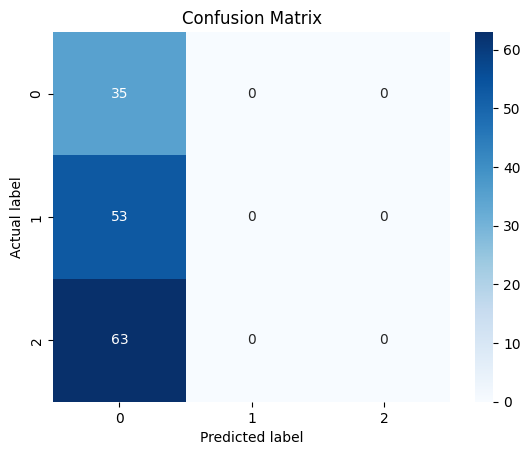

In [144]:
# Dummy Classifier for comparison
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_smote, y_train_smote)
dummy_predictions = dummy_clf.predict(X_test)

f1 = f1_score(y_test, dummy_predictions, average='micro')
print(f'Dummy f1 score: {f1}')
plot_confusion_matrix(y_test, dummy_predictions)

In [153]:
#clf = SVC(probability=True)
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = XGBClassifier(n_estimators=100, random_state=42)
#clf = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)
clf = LogisticRegression(max_iter=200, random_state=42)

In [154]:
clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score: {f1}")
print(confusion_matrix(y_test, y_pred))

F1 Score: 0.423841059602649
[[16  5 14]
 [24 19 10]
 [24 10 29]]


C:\Users\Christina\anaconda3\envs\un-fairness\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [159]:
X = df.drop(['label_panas_negative_affect', 'id'], axis=1)  # Features
y = df['label_panas_negative_affect']  # Target variable
unique_labels = y.unique()
groups = df['id']  # Group identifier for LOPO

#model = DummyClassifier(strategy='most_frequent')
#model = SVC(probability=True)
#model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = XGBClassifier(n_estimators=100, random_state=42)
model = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)
#model = LogisticRegression(max_iter=200, random_state=42)

cv = LeavePGroupsOut(n_groups=1)
scores = []
confusion_matrices = []

for train_idx, test_idx in cv.split(X, y, groups):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='micro')
    scores.append(score)
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    confusion_matrices.append(cm)

# Calculate the average performance across all LOPO iterations
average_score = np.mean(scores)
print(f'Average f1-scores across all LOPO iterations: {average_score}')
total_confusion_matrix = np.sum(confusion_matrices, axis=0)
print(total_confusion_matrix)

Average f1-scores across all LOPO iterations: 0.4951379190346513
[[111  49  30]
 [ 52  77  40]
 [ 47  45  57]]


In [220]:
df = pd.read_pickle('../data/lifesnaps/data_preprocessed.pkl')
df = df[df['label_panas_negative_affect'].notna()]
df = df.drop(columns=['label_ttm_stage', 'label_breq_self_determination', 'label_sema_negative_feelings', 'label_ipip_extraversion_category', 
                      'label_ipip_agreeableness_category', 'label_ipip_conscientiousness_category', 'label_ipip_stability_category', 
                      'label_ipip_intellect_category', 'label_stai_stress_category', 'date'])
df

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,Steps_hour14,Steps_hour15,Steps_hour16,Steps_hour17,Steps_hour18,Steps_hour19,Steps_hour20,Steps_hour21,Steps_hour22,Steps_hour23
0,621e2e8e67b776a24055b564,34.137687,57.432,89.603,95.9,14.8,78.0,0.833333,0.675,0.866667,...,191.0,33.0,342.0,1712.0,1838.0,160.0,155.0,37.0,31.0,53.0
1,621e2e8e67b776a24055b564,33.794544,57.681,94.303,95.9,15.8,80.0,0.833333,0.725,0.866667,...,120.0,24.0,446.0,377.0,3165.0,332.0,97.0,9.0,24.0,58.0
2,621e2e8e67b776a24055b564,33.794544,57.681,94.303,95.9,15.8,80.0,0.833333,0.725,0.866667,...,120.0,24.0,446.0,377.0,3165.0,332.0,97.0,9.0,24.0,58.0
3,621e2e8e67b776a24055b564,34.611011,57.481,35.216,95.9,14.6,84.0,0.966667,0.725,0.866667,...,85.0,477.0,390.0,2821.0,293.0,158.0,66.0,0.0,70.0,74.0
4,621e2e8e67b776a24055b564,34.408304,57.493,35.216,95.9,14.8,82.0,0.933333,0.725,0.833333,...,58.0,296.0,401.0,21.0,3054.0,503.0,411.0,96.0,63.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778,621e375b67b776a240290cdc,35.194505,60.061,26.159,95.9,17.2,78.0,0.766667,0.800,0.766667,...,408.0,84.0,37.0,122.0,1529.0,1194.0,5294.0,1284.0,1082.0,3753.0
7779,621e375b67b776a240290cdc,34.720564,60.280,25.764,95.9,16.8,70.0,0.700000,0.725,0.666667,...,1267.0,763.0,0.0,6.0,890.0,618.0,2671.0,1607.0,6678.0,1192.0
7780,621e375b67b776a240290cdc,34.404232,60.218,22.021,95.9,17.6,71.0,0.633333,0.725,0.766667,...,273.0,60.0,14.0,31.0,0.0,40.0,935.0,780.0,5535.0,3703.0
7781,621e375b67b776a240290cdc,34.344269,61.891,22.560,95.9,17.0,72.0,0.700000,0.725,0.733333,...,1356.0,1149.0,370.0,152.0,21.0,143.0,151.0,113.0,0.0,21.0


In [221]:
print(df.columns.tolist())

['id', 'nightly_temperature', 'nremhr', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'sleep_points_percentage', 'exertion_points_percentage', 'responsiveness_points_percentage', 'daily_temperature_variation', 'calories', 'filteredDemographicVO2Max', 'distance', 'bpm', 'lightly_active_minutes', 'moderately_active_minutes', 'very_active_minutes', 'sedentary_minutes', 'mindfulness_session', 'scl_avg', 'resting_hr', 'sleep_duration', 'minutesToFallAsleep', 'minutesAsleep', 'minutesAwake', 'minutesAfterWakeup', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'minutes_in_default_zone_1', 'minutes_below_default_zone_1', 'minutes_in_default_zone_2', 'minutes_in_default_zone_3', 'age', 'gender', 'bmi', 'label_panas_negative_affect', 'month_sin', 'weekday_sin', 'week_sin', 'day_sin', 'month_cos', 'weekday_cos', 'week_cos', 'day_cos', 'DAILY_FLOORS', 'DAILY_STEPS', 'GOAL_BASED_WEIGHT_LOSS', 'LIFETIME_DISTANCE', 'LIFETIM

In [222]:
#create_report(df).show_browser()

In [223]:
label_columns = ['label_panas_negative_affect']

# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(exclude=['float64', 'int64']).columns.tolist()

# Exclude label columns from numerical and categorical lists
numerical_cols = [col for col in numerical_cols if col not in label_columns]
categorical_cols = [col for col in categorical_cols if col not in label_columns]

# Ensure 'id' is not in these lists
if 'id' in numerical_cols:
    numerical_cols.remove('id')
    
if 'id' in categorical_cols:
    categorical_cols.remove('id')

# 1. For numerical columns:
for col in numerical_cols:
    df[col] = df.groupby('id')[col].transform(lambda x: x.fillna(x.median()))
    df[col].fillna(df[col].median(), inplace=True)

# 2. For categorical columns:
for col in categorical_cols:
    mode = df.groupby('id')[col].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else x)
    df[col] = df[col].fillna(mode)
    df[col].fillna(df[col].mode().iloc[0], inplace=True)
    
df

C:\Users\Christina\anaconda3\envs\un-fairness\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Christina\anaconda3\envs\un-fairness\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Christina\anaconda3\envs\un-fairness\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Christina\anaconda3\envs\un-fairness\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Christina\anaconda3\envs\un-fairness\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Christina\anaconda3\envs\un-fairness\lib\site-

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,Steps_hour14,Steps_hour15,Steps_hour16,Steps_hour17,Steps_hour18,Steps_hour19,Steps_hour20,Steps_hour21,Steps_hour22,Steps_hour23
0,621e2e8e67b776a24055b564,34.137687,57.432,89.603,95.9,14.8,78.0,0.833333,0.675,0.866667,...,191.0,33.0,342.0,1712.0,1838.0,160.0,155.0,37.0,31.0,53.0
1,621e2e8e67b776a24055b564,33.794544,57.681,94.303,95.9,15.8,80.0,0.833333,0.725,0.866667,...,120.0,24.0,446.0,377.0,3165.0,332.0,97.0,9.0,24.0,58.0
2,621e2e8e67b776a24055b564,33.794544,57.681,94.303,95.9,15.8,80.0,0.833333,0.725,0.866667,...,120.0,24.0,446.0,377.0,3165.0,332.0,97.0,9.0,24.0,58.0
3,621e2e8e67b776a24055b564,34.611011,57.481,35.216,95.9,14.6,84.0,0.966667,0.725,0.866667,...,85.0,477.0,390.0,2821.0,293.0,158.0,66.0,0.0,70.0,74.0
4,621e2e8e67b776a24055b564,34.408304,57.493,35.216,95.9,14.8,82.0,0.933333,0.725,0.833333,...,58.0,296.0,401.0,21.0,3054.0,503.0,411.0,96.0,63.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7778,621e375b67b776a240290cdc,35.194505,60.061,26.159,95.9,17.2,78.0,0.766667,0.800,0.766667,...,408.0,84.0,37.0,122.0,1529.0,1194.0,5294.0,1284.0,1082.0,3753.0
7779,621e375b67b776a240290cdc,34.720564,60.280,25.764,95.9,16.8,70.0,0.700000,0.725,0.666667,...,1267.0,763.0,0.0,6.0,890.0,618.0,2671.0,1607.0,6678.0,1192.0
7780,621e375b67b776a240290cdc,34.404232,60.218,22.021,95.9,17.6,71.0,0.633333,0.725,0.766667,...,273.0,60.0,14.0,31.0,0.0,40.0,935.0,780.0,5535.0,3703.0
7781,621e375b67b776a240290cdc,34.344269,61.891,22.560,95.9,17.0,72.0,0.700000,0.725,0.733333,...,1356.0,1149.0,370.0,152.0,21.0,143.0,151.0,113.0,0.0,21.0


In [224]:
df['bmi'].value_counts()

Normal         5008
Overweight     1822
Underweight     556
Obese           397
Name: bmi, dtype: int64

In [225]:
df['bmi'] = df['bmi'].replace({'Normal': 0, 'Overweight': 1, 'Underweight':2, 'Obese':3})

In [226]:
#create_report(df).show_browser()

In [230]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='label_panas_negative_affect')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print(X_train.dtypes.tolist())

for col in X_train.columns:
    X_train[col] = X_train[col].astype('float64')  

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

(5908, 147) (5908,) (1875, 147) (1875,)
[dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('

Dummy f1 score: 0.2496


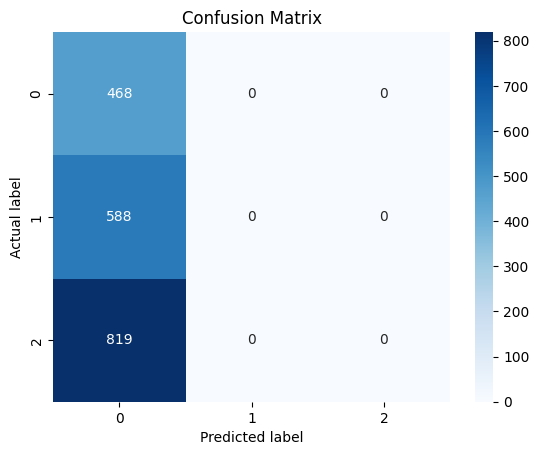

In [231]:
# Dummy Classifier for comparison
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_smote, y_train_smote)
dummy_predictions = dummy_clf.predict(X_test)

f1 = f1_score(y_test, dummy_predictions, average='micro')
print(f'Dummy f1 score: {f1}')
plot_confusion_matrix(y_test, dummy_predictions)

In [236]:
clf = SVC(kernel="rbf", gamma=0.5, C=1.0, probability=True)
#clf = RandomForestClassifier(n_estimators=100, random_state=42)
#clf = XGBClassifier(n_estimators=100, random_state=42)
#clf = GradientBoostingClassifier(n_estimators=160, learning_rate=0.3, random_state=42)
#clf = LogisticRegression(max_iter=200, random_state=42)

In [237]:
clf.fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score: {f1}")
print(confusion_matrix(y_test, y_pred))

F1 Score: 0.4368
[[  0   0 468]
 [  0   0 588]
 [  0   0 819]]


In [ ]:
# Plot Decision Boundary
DecisionBoundaryDisplay.from_estimator(
        svm,
        X_tr,
        response_method="predict",
        cmap=plt.cm.Spectral,
        alpha=0.8,
        xlabel=cancer.feature_names[0],
        ylabel=cancer.feature_names[1],
    )
 
# Scatter plot
plt.scatter(X[:, 0], X[:, 1], 
            c=y, 
            s=20, edgecolors="k")
plt.show()